# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function

import random
import numpy as np
from cecs551.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cecs551/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cecs551/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cecs551/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cecs551.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.296674
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**
Since we are computing the loss using random weghts, ideally, the probability of each class should be the same. Therefore, if N is the number of classes, then the loss should be close to -log(1/N). In our case, N=10, so the loss is close to -log(1/10) or -log(0.1).


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cecs551.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.289348 analytic: 1.289348, relative error: 1.709088e-08
numerical: -3.619355 analytic: -3.619355, relative error: 3.706943e-09
numerical: 1.578801 analytic: 1.578801, relative error: 3.404887e-08
numerical: 0.226509 analytic: 0.226509, relative error: 9.442977e-08
numerical: 1.325655 analytic: 1.325655, relative error: 1.874364e-08
numerical: -0.140483 analytic: -0.140483, relative error: 3.457554e-07
numerical: 0.800280 analytic: 0.800280, relative error: 2.997185e-08
numerical: 0.483854 analytic: 0.483854, relative error: 3.591232e-08
numerical: -1.520283 analytic: -1.520283, relative error: 2.341672e-08
numerical: 1.417484 analytic: 1.417484, relative error: 2.442176e-09
numerical: -2.065639 analytic: -2.065639, relative error: 3.612331e-08
numerical: 2.386165 analytic: 2.386164, relative error: 1.434089e-08
numerical: -1.523805 analytic: -1.523805, relative error: 8.907712e-10
numerical: -3.615536 analytic: -3.615536, relative error: 3.333169e-09
numerical: -0.548579 a

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cecs551.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.296674e+00 computed in 0.112168s
vectorized loss: 2.296674e+00 computed in 0.009647s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cecs551.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7, 1e-4]
#regularization_strengths = [2.5e-5, 5e-7, 1e-3]
#learning_rates = [1e-7, 5e-5, 1e-3, 1]
#regularization_strengths = [2.5e-4, 5e-7]
learning_rates = [1e-7, 3e-7, 4e-7, 5e-7]
regularization_strengths = [2.5e-4, 5e-4, 3e-4, 4e-4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
softmax = Softmax() 
for lr in learning_rates:
    #print("Learning rate = ", lr)
    for rs in regularization_strengths:
        #print("Regularization strength = ", rs)
        lost_hist = []
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=500, verbose=True)
        # training accuracy
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        # validation accuracy
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        # store the best validation accuracy and LinearSVM Object
        if (acc_val > best_val):
            best_val = acc_val
            best_softmax = softmax
        results[(lr, rs)] = [acc_train, acc_val]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 6.118354
iteration 100 / 500: loss 4.102861
iteration 200 / 500: loss 3.659090
iteration 300 / 500: loss 3.361591
iteration 400 / 500: loss 3.219599
iteration 0 / 500: loss 2.947377
iteration 100 / 500: loss 3.112109
iteration 200 / 500: loss 2.829010
iteration 300 / 500: loss 2.897496
iteration 400 / 500: loss 2.904348
iteration 0 / 500: loss 2.903105
iteration 100 / 500: loss 2.913558
iteration 200 / 500: loss 2.466831
iteration 300 / 500: loss 2.718533
iteration 400 / 500: loss 2.650691
iteration 0 / 500: loss 2.469878
iteration 100 / 500: loss 2.397001
iteration 200 / 500: loss 2.457891
iteration 300 / 500: loss 2.499691
iteration 400 / 500: loss 2.727518
iteration 0 / 500: loss 2.404259
iteration 100 / 500: loss 2.587829
iteration 200 / 500: loss 2.358431
iteration 300 / 500: loss 2.699989
iteration 400 / 500: loss 2.418017
iteration 0 / 500: loss 2.339495
iteration 100 / 500: loss 2.308345
iteration 200 / 500: loss 2.239205
iteration 300 / 500: loss 2.2370

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.345000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*:
Since the SVM loss is the Hinge Loss = max(0, scores), the loss depends on individual data points. On the other hand, the Softmax loss is probabilistic by nature and is, therefore, dependent on all the data points to decide the loss. So adding a new data point always affects the loss.

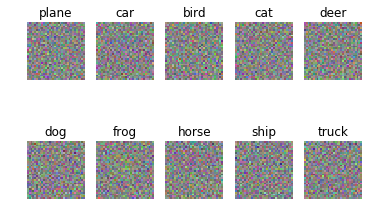

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])